# Clasificación de imágenes usando una red profunda

**Profesor:** Roberto Muñoz <br />
**E-mail:** <rmunoz@metricarts.com> <br />

**Colaborador:** Sebastián Arpón <br />
**E-mail:** <rmunoz@metricarts.com> <br />


Usaremos el dataset de perros y gatos. El dataset completo se puede descargar desde el link https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17353652793812757963, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10196979876
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3175699111221355166
 physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:09:00.0, compute capability: 5.2"]

In [3]:
import tensorflow as tf
from tensorflow.contrib.data.python.ops import prefetching_ops

opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
conf = tf.ConfigProto(gpu_options=opts)

tf.enable_eager_execution(config=conf)
tf.device("/gpu:0")

In [4]:
tf.__version__

'1.9.0'

In [5]:
import os
import glob
import requests
import zipfile

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Descargamos los datos

Descargamos un dataset pequeño de perros y gatos. Lo descargamos ejecutando el siguiente código

In [6]:
data_url = "https://metriclearning.blob.core.windows.net/tensorflow/cats_and_dogs_medium.zip"

# Puede elegir entre diferentes datasets
# Pequeño: https://metriclearning.blob.core.windows.net/tensorflow/cats_and_dogs_small.zip
# Mediano: https://metriclearning.blob.core.windows.net/tensorflow/cats_and_dogs_medium.zip
# Grande: https://metriclearning.blob.core.windows.net/tensorflow/cats_and_dogs_large.zip

data_dir = "data"
data_file = os.path.join(data_dir, "cats_and_dogs_medium.zip")

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

response = requests.get(data_url)
response_data = response.content

with open(data_file, 'wb') as f:
    f.write(response_data)

with open(data_file, 'rb') as f:
    zf = zipfile.ZipFile(f)
    zf.extractall(data_dir)

Hacemos un resize de las imágenes a 150 x 150 pixels

In [7]:
def read_dir(directory):
    cats = glob.glob(os.path.join(directory,"cats") + '/*.jpg')
    dogs = glob.glob(os.path.join(directory,"dogs") + '/*.jpg')
    m_images = cats + dogs
    
    m_labels = []
    m_labels.extend([CAT] * len(cats))
    m_labels.extend([DOG] * len(dogs))
    assert len(m_labels) == len(m_images)
    LABELS_DIMENSIONS = 2
    m_labels = tf.one_hot(m_labels, LABELS_DIMENSIONS)
    print("Encontre %d imagenes y etiquetas en %s" %(len(m_images),directory))
    return m_images, m_labels

def load_image(path_to_image, p_label):
    m_label = p_label
    m_image = tf.read_file(path_to_image)
    m_image = tf.image.decode_jpeg(m_image)
    m_image = tf.image.resize_images(m_image,(150,150))
    m_image = m_image / 255
    return m_image, m_label

In [8]:
data_dir = "data/cats_and_dogs_medium"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir , "validation")

CAT = 0
DOG = 1

print("Carpeta con imagenes para el entrenamiento: ", train_dir)
print("Carpeta con imagenes para la validación: ", val_dir)
print()

train_images, train_labels = read_dir(train_dir)
val_images, val_labels = read_dir(val_dir)

Carpeta con imagenes para el entrenamiento:  data/cats_and_dogs_medium\train
Carpeta con imagenes para la validación:  data/cats_and_dogs_medium\validation

Encontre 1600 imagenes y etiquetas en data/cats_and_dogs_medium\train
Encontre 400 imagenes y etiquetas en data/cats_and_dogs_medium\validation


(150, 150, 3)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)


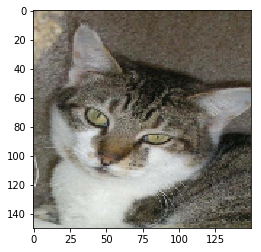

In [9]:
i=np.random.randint(len(train_images))

img, label = load_image(train_images[i], train_labels[i])

print(img.shape)
print(label)

plt.imshow(img)

## 2. Cargamos los datos en TensforFlow usando `tf.data`

In [27]:
batch_size = 128
buffer_size = 1000

train_data_set = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_data_set = train_data_set.shuffle(buffer_size).map(load_image).batch(batch_size)
#train_data_set = train_data_set.prefetch(buffer_size=4)
train_data_set = train_data_set.apply(tf.contrib.data.prefetch_to_device("/gpu:0", buffer_size=2))
#train_data_set = train_data_set.apply(prefetching_ops.copy_to_device("/gpu:0")) # Only works in TF > 1.10

val_data_set = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_data_set = val_data_set.shuffle(buffer_size).map(load_image).batch(len(val_images))

La variable train_data_set contiene las imagenes del dataset de entrenamiento ordenadas en batches. Imprimimos en pantalla el tipo de dato y recorrimos cada batch.

In [28]:
print(type(train_data_set))

<class 'tensorflow.contrib.data.python.ops.prefetching_ops._PrefetchToDeviceDataset'>


In [29]:
print(type(val_data_set))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [30]:
for batch_i, (batch_image, batch_label) in enumerate(train_data_set):
    print("Batch iteration: ", batch_i)
    print("Batch image type: ", type(batch_image))
    print("Batch image shape: ", batch_image.shape)
    print("Batch label type: ", type(batch_label))
    print("Batch label shape: ", batch_label.shape)
    print()

Batch iteration:  0
Batch image type:  <class 'EagerTensor'>
Batch image shape:  (128, 150, 150, 3)
Batch label type:  <class 'EagerTensor'>
Batch label shape:  (128, 2)

Batch iteration:  1
Batch image type:  <class 'EagerTensor'>
Batch image shape:  (128, 150, 150, 3)
Batch label type:  <class 'EagerTensor'>
Batch label shape:  (128, 2)

Batch iteration:  2
Batch image type:  <class 'EagerTensor'>
Batch image shape:  (128, 150, 150, 3)
Batch label type:  <class 'EagerTensor'>
Batch label shape:  (128, 2)

Batch iteration:  3
Batch image type:  <class 'EagerTensor'>
Batch image shape:  (128, 150, 150, 3)
Batch label type:  <class 'EagerTensor'>
Batch label shape:  (128, 2)

Batch iteration:  4
Batch image type:  <class 'EagerTensor'>
Batch image shape:  (128, 150, 150, 3)
Batch label type:  <class 'EagerTensor'>
Batch label shape:  (128, 2)

Batch iteration:  5
Batch image type:  <class 'EagerTensor'>
Batch image shape:  (128, 150, 150, 3)
Batch label type:  <class 'EagerTensor'>
Batc

## 3. Definimos el modelo y lo entrenamos

### Definimos la arquitectura de la red

Usamos el método `AdamOptimizer` como funcion de optimización

In [86]:
tf.keras.backend.clear_session()

In [87]:
def create_model():

    model = tf.keras.Sequential()

    model.add(tf.layers.Conv2D(16, (5,5), activation=tf.nn.relu, input_shape=(150,150,3)))

    model.add(tf.layers.MaxPooling2D(pool_size=(2,2),strides=2))

    model.add(tf.layers.Conv2D(64,(3,3),activation=tf.nn.relu))
    model.add(tf.layers.MaxPooling2D(pool_size=(2,2),strides=2))
    model.add(tf.layers.Conv2D(128,(3,3),activation=tf.nn.relu))
    model.add(tf.layers.MaxPooling2D(pool_size=(2,2),strides=2))
    model.add(tf.layers.Conv2D(128,(3,3),activation=tf.nn.relu))
    model.add(tf.layers.MaxPooling2D(pool_size=(2,2),strides=2))
    model.add(tf.layers.Flatten())
    model.add(tf.layers.Dense(512,activation=tf.nn.relu))
    model.add(tf.layers.Dense(2,activation=tf.nn.softmax))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=tf.train.AdamOptimizer(),
                  metrics=['accuracy'])
    
    return model
    
model = create_model()    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 146, 146, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
__________

### Definimos dos funciones para calcular las metricas de precision y recall

In [88]:
def precision(labels, predictions, weights=None):
    conf_matrix = tf.confusion_matrix(labels, predictions, num_classes=2)
    tp_and_fp = tf.reduce_sum(conf_matrix, axis=0)
    tp = tf.diag_part(conf_matrix)
    precision_scores = tp/(tp_and_fp)
    if weights:
        precision_score = tf.multiply(precision_scores, weights)/tf.reduce_sum(weights)
    else:
        precision_score = tf.reduce_mean(precision_scores)        
    return precision_score

def recall(labels, predictions, weights=None):
    conf_matrix = tf.confusion_matrix(labels, predictions, num_classes=2)
    tp_and_fn = tf.reduce_sum(conf_matrix, axis=1)
    tp = tf.diag_part(conf_matrix)
    recall_scores = tp/(tp_and_fn)
    if weights:
        recall_score = tf.multiply(recall_scores, weights)/tf.reduce_sum(weights)
    else:
        recall_score = tf.reduce_mean(recall_scores)        
    return recall_score

### Entrenamos el modelo usando `train_on_batch()`

In [89]:
checkpoint_dir='results'

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

In [90]:
EPOCHS = 100
N_BATCHES = int(np.ceil(len(train_images)/batch_size))

train_loss_epoch_list=[]
train_acc_epoch_list=[]

val_loss_epoch_list=[]
val_accuracy_epoch_list=[]
val_precision_epoch_list=[]
val_recall_epoch_list=[]

for epoch in range(EPOCHS):
    
    progbar = tf.keras.utils.Progbar(N_BATCHES)
    for (batch, (images, labels)) in enumerate(train_data_set):
        train_loss, train_accuracy = model.train_on_batch(images, labels)
        progbar.add(1, values=[("train loss", train_loss), ("acc", train_accuracy)])

    model.save_weights(os.path.join(checkpoint_dir, "model_cats_and_dogs_{:04d}.ckpt".format(epoch+1)))
        
    train_loss_epoch_list.append(float(train_loss))
    train_acc_epoch_list.append(float(train_accuracy))
    print('Entrenamiento época #%d\t Loss: %.6f\t Accuracy:  %.6f\t'% (epoch+1, train_loss, train_accuracy))
    
    iterator = val_data_set.make_one_shot_iterator()
    images, labels = iterator.get_next()  
    val_loss, val_accuracy = model.evaluate(images, labels)
    
    preds_value = model.predict_classes(images)
    labels_value = tf.argmax(labels, axis=1).numpy()
       
    val_precision = precision(labels_value, preds_value, weights=None)
    val_recall = recall(labels_value, preds_value, weights=None)
    
    val_loss_epoch_list.append(float(val_loss))
    val_accuracy_epoch_list.append(float(val_accuracy))
    val_precision_epoch_list.append(float(val_precision))
    val_recall_epoch_list.append(float(val_recall))
    
    print('Validacion época #%d\t Loss: %.6f\t Accuracy:  %.6f\t' % (epoch+1, val_loss, val_accuracy))
    print()


13/13 [==============================] - 4s 290ms/step - train loss: 0.8148 - acc: 0.5871
Entrenamiento época #1	 Loss: 0.653122	 Accuracy:  0.671875	
400/400 [==============================] - 0s 1ms/step
Validacion época #1	 Loss: 0.710401	 Accuracy:  0.500000	

13/13 [==============================] - 4s 289ms/step - train loss: 0.7082 - acc: 0.5078
Entrenamiento época #2	 Loss: 0.690418	 Accuracy:  0.687500	
400/400 [==============================] - 0s 1ms/step
Validacion época #2	 Loss: 0.692938	 Accuracy:  0.500000	

13/13 [==============================] - 4s 288ms/step - train loss: 0.6928 - acc: 0.5144
Entrenamiento época #3	 Loss: 0.691034	 Accuracy:  0.515625	
400/400 [==============================] - 0s 1ms/step
Validacion época #3	 Loss: 0.688223	 Accuracy:  0.570000	

13/13 [==============================] - 4s 289ms/step - train loss: 0.6966 - acc: 0.5457
Entrenamiento época #4	 Loss: 0.692503	 Accuracy:  0.515625	
400/400 [==============================] - 0s 1ms/step

400/400 [==============================] - 0s 1ms/step
Validacion época #31	 Loss: 2.342008	 Accuracy:  0.652500	

13/13 [==============================] - 4s 288ms/step - train loss: 0.0088 - acc: 0.9988
Entrenamiento época #32	 Loss: 0.005225	 Accuracy:  1.000000	
400/400 [==============================] - 0s 1ms/step
Validacion época #32	 Loss: 2.205672	 Accuracy:  0.632500	

13/13 [==============================] - 4s 296ms/step - train loss: 0.0115 - acc: 0.9970
Entrenamiento época #33	 Loss: 0.001702	 Accuracy:  1.000000	
400/400 [==============================] - 0s 1ms/step
Validacion época #33	 Loss: 2.107873	 Accuracy:  0.680000	

13/13 [==============================] - 4s 290ms/step - train loss: 0.0241 - acc: 0.9940
Entrenamiento época #34	 Loss: 0.003715	 Accuracy:  1.000000	
400/400 [==============================] - 0s 1ms/step
Validacion época #34	 Loss: 2.050646	 Accuracy:  0.690000	

13/13 [==============================] - 4s 289ms/step - train loss: 0.0202 - acc: 0

13/13 [==============================] - 4s 289ms/step - train loss: 5.4854e-05 - acc: 1.0000
Entrenamiento época #62	 Loss: 0.000038	 Accuracy:  1.000000	
400/400 [==============================] - 0s 1ms/step
Validacion época #62	 Loss: 2.609888	 Accuracy:  0.657500	

13/13 [==============================] - 4s 288ms/step - train loss: 5.0906e-05 - acc: 1.0000
Entrenamiento época #63	 Loss: 0.000024	 Accuracy:  1.000000	
400/400 [==============================] - 0s 1ms/step
Validacion época #63	 Loss: 2.616063	 Accuracy:  0.657500	

13/13 [==============================] - 4s 288ms/step - train loss: 4.8483e-05 - acc: 1.0000
Entrenamiento época #64	 Loss: 0.000032	 Accuracy:  1.000000	
400/400 [==============================] - 0s 1ms/step
Validacion época #64	 Loss: 2.622425	 Accuracy:  0.657500	

13/13 [==============================] - 4s 289ms/step - train loss: 4.7832e-05 - acc: 1.0000
Entrenamiento época #65	 Loss: 0.000078	 Accuracy:  1.000000	
400/400 [======================

13/13 [==============================] - 4s 287ms/step - train loss: 1.6450e-05 - acc: 1.0000
Entrenamiento época #92	 Loss: 0.000014	 Accuracy:  1.000000	
400/400 [==============================] - 0s 1ms/step
Validacion época #92	 Loss: 2.748720	 Accuracy:  0.650000	

13/13 [==============================] - 4s 288ms/step - train loss: 1.5979e-05 - acc: 1.0000
Entrenamiento época #93	 Loss: 0.000013	 Accuracy:  1.000000	
400/400 [==============================] - 0s 1ms/step
Validacion época #93	 Loss: 2.751719	 Accuracy:  0.650000	

13/13 [==============================] - 4s 287ms/step - train loss: 1.5951e-05 - acc: 1.0000
Entrenamiento época #94	 Loss: 0.000024	 Accuracy:  1.000000	
400/400 [==============================] - 0s 1ms/step
Validacion época #94	 Loss: 2.754750	 Accuracy:  0.650000	

13/13 [==============================] - 4s 287ms/step - train loss: 1.5024e-05 - acc: 1.0000
Entrenamiento época #95	 Loss: 0.000010	 Accuracy:  1.000000	
400/400 [======================

### Graficamos la evolución de la función de costo

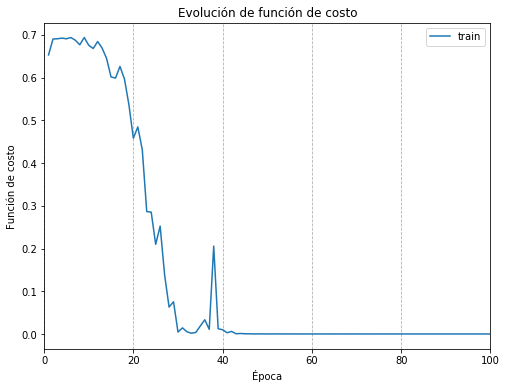

In [91]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

x=x=np.arange(EPOCHS)+1
ax.plot(x, train_loss_epoch_list, label="train")

plt.xlabel("Época")
plt.ylabel("Función de costo")
plt.legend(loc=1)
plt.xlim(0,100)
ax.grid(which='major', axis='x', linestyle='--')

plt.title("Evolución de función de costo")
fig.savefig('results/loss_function_cats_and_dogs.png')

### Graficamos la evolución del accuracy

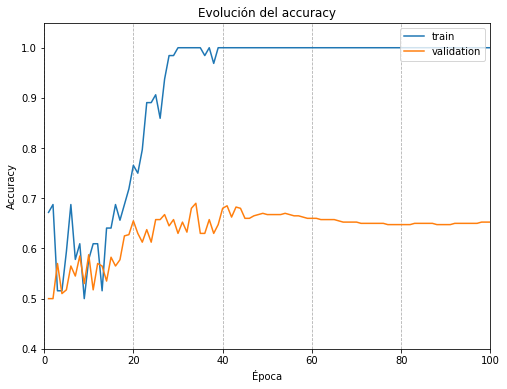

In [92]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

x=np.arange(EPOCHS)+1
ax.plot(x, train_acc_epoch_list, label="train")
ax.plot(x, val_accuracy_epoch_list, label="validation")

plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend(loc=1)
plt.xlim(0,100)
plt.ylim(0.4,1.05)
ax.grid(which='major', axis='x', linestyle='--')

plt.title("Evolución del accuracy")
fig.savefig('results/accuracy_cats_and_dogs.png')

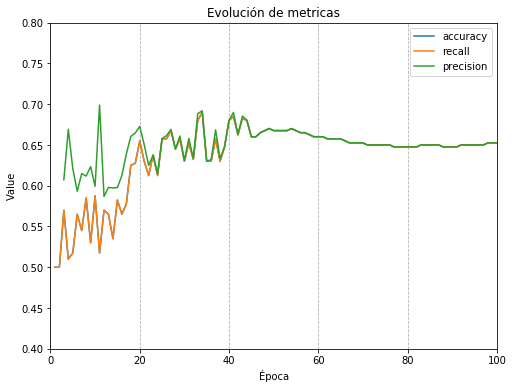

In [93]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

x=np.arange(EPOCHS)+1
ax.plot(x, val_accuracy_epoch_list, label="accuracy")
ax.plot(x, val_recall_epoch_list, label="recall")
ax.plot(x, val_precision_epoch_list, label="precision")

plt.xlabel("Época")
plt.ylabel("Value")
plt.legend(loc=1)
plt.xlim(0,100)
plt.ylim(0.4,0.8)
ax.grid(which='major', axis='x', linestyle='--')

plt.title("Evolución de metricas")
fig.savefig('results/metrics_cats_and_dogs.png')

## 4. Revisamos el rendimiento del modelo en diferentes épocas

Listamos los pesos que guardamos para cada época

In [84]:
pattern = os.path.join("results/model_cats*.ckpt")
checkpoints = sorted(glob.glob(pattern))

for file in checkpoints:
    print(file)

Para validar el rendimiento del modelo usaremos el dataset de validación `val_data_set`

Recuperamos los pesos para la **época 1** y evaluamos el modelo.

In [ ]:
weight_file = 'results/model_cats_and_dogs_0001.ckpt'

model = create_model()
model.load_weights(weight_file)

iterator = val_data_set.make_one_shot_iterator()
images, labels = iterator.get_next()  

loss, acc = model.evaluate(images, labels)

print("Evaluation - Model accuracy: {:.4f}".format(acc))

Recuperamos los pesos para la **época 30** y evaluamos el modelo.

In [ ]:
weight_file = 'results/model_cats_and_dogs_0030.ckpt'

model = create_model()
model.load_weights(weight_file)

iterator = val_data_set.make_one_shot_iterator()
images, labels = iterator.get_next()  

loss, acc = model.evaluate(images, labels)

print("Evaluation - Model accuracy: {:.4f}".format(acc))

¿Que tál si revisamos el gráfico de evolución del accuracy y elegimos un época intermedia?

Vemos que la **época 6** tiene un accuracy más alto que el resto.

In [ ]:
weight_file = 'results/model_cats_and_dogs_0006.ckpt'

model = create_model()
model.load_weights(weight_file)

iterator = val_data_set.make_one_shot_iterator()
images, labels = iterator.get_next()  

loss, acc = model.evaluate(images, labels)

print("Evaluation - Model accuracy: {:.4f}".format(acc))

Definitivamente los pesos obtenidos en la época 6 son los mejores que obtuvimos en este entrenamiento. Usaremos estos pesos para evaluar el rendimiento en imágenes nuevas.

## 5. Descargamos imágenes nuevas y predecimos a qué clase pertencen

In [ ]:
import requests
import io
import imageio
from skimage.transform import resize

In [ ]:
url="https://misanimales.com/wp-content/uploads/2014/12/gato-enfermo.jpg"

response = requests.get(url, stream=True)
im = imageio.imread(io.BytesIO(response.content))

plt.imshow(im)

Revisamos las dimensiones de la imagen

In [ ]:
print(type(im))
print(im.shape)
print(np.min(im))
print(np.max(im))

Para usar el método predict() de TensorFlow primero debemos cambiar el tamaño de la imagen a 150x150 pixels, luego transformar la imagen en un Tensor y finalmente agregar una dimensión extra al comienzo

In [ ]:
im_np = np.array(im)
im_np = resize(im_np, (150,150))
im_np = im_np.astype('float32')

im_tf = tf.convert_to_tensor(im_np)
im_tf = tf.expand_dims(im_tf, 0)

In [ ]:
np.max(im_np)

In [ ]:
model.predict(im_tf)

In [ ]:
model.predict_classes(im_tf)

In [ ]:
def predict_url(url):
    response = requests.get(url, stream=True)
    im = imageio.imread(io.BytesIO(response.content))
    
    plt.imshow(im)
    plt.show()
    
    im_np = np.array(im)
    im_np = resize(im_np, (150,150))
    im_np = im_np.astype('float32')

    im_tf = tf.convert_to_tensor(im_np)
    im_tf = tf.expand_dims(im_tf, 0)
    
    predict_class = model.predict_classes(im_tf)
    
    if predict_class == 0:
        print("Predicción del modelo: Gato")
    elif predict_class == 1:
        print("Predicción del modelo: Perro")

In [ ]:
url="https://misanimales.com/wp-content/uploads/2014/12/gato-enfermo.jpg"
predict_url(url)

In [ ]:
url="https://s3-eu-west-1.amazonaws.com/barkibu-blog/blog+images/mi-perro-tiene-hipo-muy-seguido-que-le-pasa/perro-hipo-1.jpg"
predict_url(url)